## Import packages ##

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
import sys
import math

## Helper functions ##

In [68]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def line_eq_bottom(x1, y1, x2, y2, yExt):
    """
    This function claculates a third pair of coordinates for a line in a lower part of image
    A*x + B*y + C = 0
    """
    A = (y1 - y2)
    if (math.fabs(A) < 0.001): # Prevention of division by zero
            A = 0.001
    B = (x2 - x1)
    C = (x1 * y2) - (x2 * y1)
    xExt = math.floor(((-B * yExt) - C) / A)
    return xExt

def line_eq_up(x1, y1, x2, y2, yExt):
    """
    This function claculates a third pair of coordinates for a line in a upper part of image
    A*x + B*y + C = 0
    """
    A = (y1 - y2)
    B = (x2 - x1)
    C = (x1 * y2) - (x2 * y1)
    if (math.fabs(A) < 0.001): # Prevention of division by zero
        A = 0.001
    xExt = math.floor(((-B * yExt) - C) / A)
    return xExt

def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imshape = img.shape
    # Create two empty numpy vectors
    x1=np.zeros(lines.shape[0],dtype=int)
    y1=np.zeros(lines.shape[0],dtype=int)
    
    # Copy scalar coordinates from lines to these vectors
    for i in range(lines.shape[0]):
        x1[i] = np.asscalar(lines[i][0][0])
        y1[i] = np.asscalar(lines[i][0][1])
    
    # Move to Python's regular lists
    raw_x = x1.tolist()
    raw_y = y1.tolist()
    
    # ---Right Line---
    # Define lower point of the right line
    low_right_x = max(raw_x)
    index_y = raw_x.index(low_right_x) # Find its index
    low_right_y = y1[index_y] # Use index to find correspondant y-coordinate
    
    # Define higher point of the right line
    #high_right_x = min(i for i in raw_x if i > top_right[0])
    high_right_x = min(i for i in raw_x if i > (math.ceil(0.55 * imshape[1])))
    index_y = raw_x.index(high_right_x) # Find its index
    high_right_y = y1[index_y] # Use index to find correspondant y-coordinate
    
    # ---Left Line---
    # Define lower point of the left corner
    low_left_x = min(raw_x)
    index_y = raw_x.index(low_left_x) # Find its index
    low_left_y =  y1[index_y] # Use index to find correspondant y-coordinate
    
    # Define higher point of the left line
    #high_left_x = max(i for i in raw_x if i < top_left[0])
    high_left_x = max(i for i in raw_x if i < (math.ceil(0.47 * imshape[1])))
    index_y = raw_x.index(high_left_x) # Find its index
    high_left_y = y1[index_y] # Use index to find correspondant y-coordinate

    # Equalize y coordinate on both lines
    
    # Lower part
    # Left side
    yExt = imshape[0]
    xExt = line_eq_bottom(high_right_x, high_right_y,  low_right_x, low_right_y, yExt)
    # Right line
    cv2.line(img,(high_right_x,high_right_y), (low_right_x ,low_right_y), color, thickness)
    cv2.line(img,(low_right_x ,low_right_y),(xExt,yExt), color, thickness) 

    xExt = line_eq_bottom(high_left_x, high_left_y, low_left_x, low_left_y, yExt)
    # Left lines
    cv2.line(img,(high_left_x, high_left_y), (low_left_x, low_left_y), color, thickness)
    cv2.line(img,(low_left_x, low_left_y), (xExt, yExt), color, thickness)
    
    # Upper part
    if (high_left_y > high_right_y):
        yExt = high_left_y
        xExt = line_eq_up(low_right_x, low_right_y, high_right_x, high_right_y, yExt)
        # Right lines
        cv2.line(img, (low_right_x ,low_right_y), (high_right_x, high_right_y), color, thickness)
        cv2.line(img, (high_right_x, high_right_y), (xExt, yExt), color, thickness) 
    else:
        yExt = high_right_y
        xExt = line_eq_up(low_left_x, low_left_y, high_left_x, high_left_y, yExt)
        # Left lines
        cv2.line(img, (low_left_x, low_left_y), (high_left_x, high_left_y), color, thickness)
        cv2.line(img, (high_left_x, high_left_y), (xExt, yExt), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

------

## Image Processing Section ##

## Read image ##

This image is: solidWhiteRight.jpg of type: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


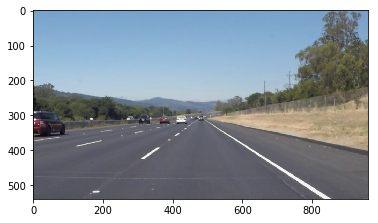

Other images availabe: solidWhiteRight.jpg, whiteCarLaneSwitch.jpg, solidYellowCurve.jpg, solidYellowLeft.jpg, solidYellowCurve2.jpg, solidWhiteCurve.jpg


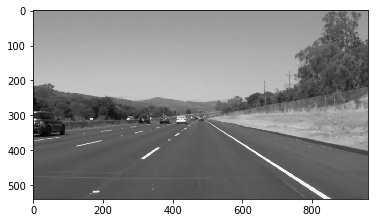

In [69]:
# Image name
imagename = 'solidWhiteRight.jpg'
foldername = "test_images/"

# Open an image
try:
    image = mpimg.imread(foldername + imagename)
except FileNotFoundError:
    print("File not found! Choose one from the following options:")
    print('%s' % ', '.join(map(str, os.listdir(foldername))))

# Show some stats and the image
# The image.shape returns a tuple of number of rows, columns and channels (if image is color)
print('This image is:', imagename, 'of type:', type(image), 'with dimensions:', image.shape)
image_size = [image.shape[1], image.shape[0]]

plt.imshow(image)  
plt.show()

# Show other available files
print('Other images availabe: %s' % ', '.join(map(str, os.listdir(foldername))))

# Apply the Grayscale transform
image_gray = grayscale(image)
plt.imshow(image_gray, cmap='gray')  
plt.show()

## Apply Gaussian smoothing ##

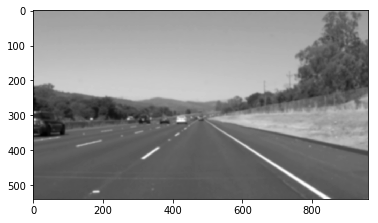

In [70]:
# Define a kernel size
kernel_size = 11 #Should be an odd number
image_gray_blur = gaussian_blur(image_gray, kernel_size)
plt.imshow(image_gray_blur, cmap='gray')  
plt.show()

## Apply the Canny transform ##

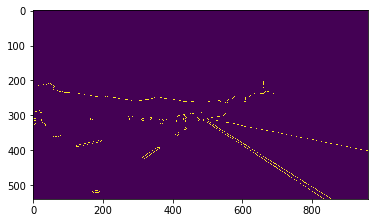

In [71]:
low_threshold = 30
high_threshold = 150
image_edges = canny(image_gray_blur, low_threshold, high_threshold)
plt.imshow(image_edges)  
plt.show()

## Define region of interest ##

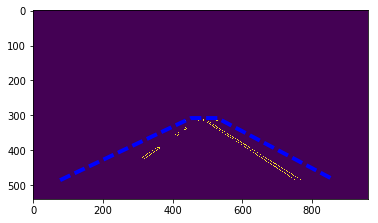

In [72]:
image_mask = np.zeros_like(image_edges)   
ignore_mask_color = 255  

# Define a four sided polygon to mask
imshape = image.shape
bottom_left = (math.ceil(0.080 * imshape[1]), math.ceil(0.9 * imshape[0]))
top_left = (math.ceil(0.47 * imshape[1]), math.ceil(0.57 * imshape[0]))
top_right = (math.ceil(0.55 * imshape[1]), math.ceil(0.57 * imshape[0]))
bottom_right = (math.ceil(0.900 * imshape[1]), math.ceil(0.9 * imshape[0]))

vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
#print(vertices)

image_masked_edges = region_of_interest(image_edges, vertices)
plt.imshow(image_masked_edges)
x = [bottom_left[0], top_left[0], top_right[0], bottom_right[0]]
y = [bottom_left[1], top_left[1], top_right[1], bottom_right[1]]
plt.plot(x, y, 'b--', lw=4)
plt.show()

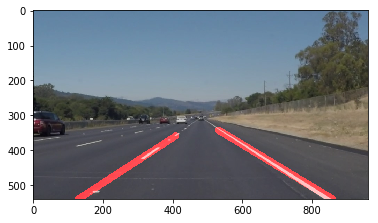

In [73]:
# Apply the Hough transform
rho = 1 # distance resolution in pixels of the Hough grid #1
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell) #1
min_line_length = 10 #minimum number of pixels making up a line #5
max_line_gap = 15    # maximum gap in pixels between connectable line segments #1
image_line = np.copy(image)*0 # creating a blank to draw lines on

# Output "lines" is a list containing endpoints of detected line segments
image_line = hough_lines(image_masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

# Create a "color" binary image to combine with line image
#color_edges = np.dstack((image_masked_edges, image_masked_edges, image_masked_edges)) 
color_edges = np.dstack((image, image, image))

# Draw the lines on the edge image
image_lines_over_orginal = weighted_img(image_line, image, α=0.8, β=1., λ=0.)
plt.imshow(image_lines_over_orginal)  
plt.show()

-----

## Video Processing Section ##

In [74]:
# Maybe it is necessary execute this section once to fix ffmpeg error
#import imageio
#imageio.plugins.ffmpeg.download()

In [75]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Image processing function ##

In [76]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    image_gray = grayscale(image)
    kernel_size = 11 #Should be odd number
    image_gray_blur = gaussian_blur(image_gray, kernel_size)
    low_threshold = 30
    high_threshold = 150
    image_edges = canny(image_gray_blur, low_threshold, high_threshold)
    image_mask = np.zeros_like(image_edges)   
    ignore_mask_color = 255  

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    bottom_left = (math.ceil(0.080 * imshape[1]), math.ceil(0.9 * imshape[0]))
    top_left = (math.ceil(0.47 * imshape[1]), math.ceil(0.57 * imshape[0]))
    top_right = (math.ceil(0.55 * imshape[1]), math.ceil(0.57 * imshape[0]))
    bottom_right = (math.ceil(0.900 * imshape[1]), math.ceil(0.9 * imshape[0]))
          
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    #print(vertices)
    image_masked_edges = region_of_interest(image_edges, vertices)
    
    # Apply the Hough transform
    rho = 1 # distance resolution in pixels of the Hough grid #1
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1     # minimum number of votes (intersections in Hough grid cell) #1
    min_line_length = 10 #minimum number of pixels making up a line #5
    max_line_gap = 15    # maximum gap in pixels between connectable line segments #1
    image_line = np.copy(image)*0 # creating a blank to draw lines on

    # Output "lines" is a list containing endpoints of detected line segments
    image_line = hough_lines(image_masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((image, image, image))
    
    # Draw the lines on the edge image
    image_lines_over_orginal = weighted_img(image_line, image, α=0.8, β=1., λ=0.)
    
    return image_lines_over_orginal

In [77]:
# Debug step
#plt.imshow(process_image(image_lines_over_orginal))  
#plt.show()

## Process an input video ##

In [78]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
#white_output = 'test_videos_output/solidWhiteRight.mp4'
#white_output = 'test_videos_output/challenge.mp4'

clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")#.subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#clip1 = VideoFileClip("test_videos/challenge.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:15<00:00, 44.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1min 24s, sys: 388 ms, total: 1min 25s
Wall time: 15.5 s


In [29]:
# See results here or go to test_videos_output folder
#HTML("""
#<video width="960" height="540" controls>
#  <source src="test_videos_output/solidWhiteRight.mp4">
#</video>
#""".format(white_output))